# Efficiency parameter calculation

- [Constant efficiency](#constant-efficiency)
- [Piecewise linear efficiency](#piecewise-linear-efficiency---breakpoint-calcualtion)

## Constant efficiency

<a id='another_cell'></a>

If the model has to be strictly linear all efficiencies have to be modeled as constant efficiencies.

Using the helper variables $soc_{loss}$, $P_{in,stor}$ and $P_{out,stor}$ it might seem possible to use linear equations to calculate these helper variable. E.g. instead of
$$P_{in,stor} = P_{in}\cdot \eta_{in}$$
using
$$P_{in,stor} = a_{in}\cdot P_{in} + b_{in}$$
to model the efficiency. Since this would still be linear, it seems a better way to represent the efficiency. 

However, the problem with this approach is, that even if $P_{in}$ is zero, the value calculated for $P_{in,stor}$ is greater than zero due to the constant part of the equation, effectively "generating" energy. This, of course, is physically impossible.

The same holds true for $soc_{loss}$. While there would not be any energy "generated", losses would occur even if the state of charge is zero, leading to a negative state of charge, and thus "destroying" energy.

The following code can be used to calculate a constant efficiency for a given data set x and y, for which the efficiency is defined by y divided by x.

The code returns three different values, for a constant efficiency, based on three different ways to calculate it:

1. The constant efficiency is equal to the maximum efficiency of the data set
2. The constant efficiency is equal to the mean efficiency of the data set
3. The constant efficiency is equal to the slope of a linear regression of the data set, provided the intercept is zero

In [25]:
import os
from efficiency_calculation_script import find_constant_efficiency

# define path to data file
parent_dir = os.path.realpath("..")
data_file = os.path.realpath(
    os.path.join(
        parent_dir,
        "design_plan_simulation_results",
        "phs_discharging_efficiency_data.csv",
    )
)

# define column labels of input data
x_value_label = "P_out_stor"
y_value_label = "P_out_rel"
eff_value_label = "eta_out"

# calculate constant efficiency
eta_reg, eta_max, eta_mean = find_constant_efficiency(
    data_file, x_value_label, y_value_label, eff_value_label
)

print("\n----------------------------- EFFICIENCY ----------------------------\n")
print("\n\t constant efficiency equal to max efficiency: {:.6f}\n".format(eta_max))
print("\n\t constant efficiency equal to mean efficiency: {:.6f}\n".format(eta_mean))
print(
    "\n\t constant efficiency equal to linear regression slope: {:.6f}\n".format(
        eta_reg
    )
)
print("\n---------------------------------------------------------------------\n")



----------------------------- EFFICIENCY ----------------------------


	 constant efficiency equal to max efficiency: 0.884000


	 constant efficiency equal to mean efficiency: 0.850149


	 constant efficiency equal to linear regression slope: 0.866813


---------------------------------------------------------------------



## Piecewise linear efficiency - breakpoint calcualtion

To calculate the optimal position of a given number of breakpoints we use the python package [pwlf](https://pypi.org/project/pwlf/), which uses a global optimization to find the breakpoint locations that minimize the sum of squares error.

As input data we use the results of the design plan simulations and specify the number of breakpoints. 

However, the resulting breakpoints do not necessarily cover the complete defined range of the x variable. For example the defined range of the charging power would be $P_{in} \in [0, 1]$, while the range of data obtained from the design plan might be $P_{in} \in [0.1023, 0.9986]$. 

The reason behind this is the calculation of the design plan itself (see [chapter on design plan](../toolchain_with_phs_example.ipynb)). To deal with this problem, we added a function `process_breakpoints` which extends the breakpoints to include the complete defined range of the x variable. This is done by extending the first and last segment to include the minimum and maximum x value of the defined range, as follows:

1. The first and the second calculated breakpoints are used to determine the slope and intercept of the first segment. 
2. The resulting linear equation is used to calculate the y value for the given minimum x value.
3. Analogues the last and second to last breakpoints are used to calculate the slope and intercept of the last segment.
4. Again the resulting linear equation is used to calculate the y value for the given maximum x value.
5. The first and last breakpoint are replaced by these new points

If the data, for which the breakpoints are calculated, contains a minimal part load, the approach has to be adjusted. A minimal part load generally means, that the defined range for $x$ looks something like this: $x \in [0] \cup [x_{min}, x_{max}]$, so $x$ can be either zero or between $x_{min}$ and $x_{max}$. 

In the example above the defined range of the charging power is actually $P_{in} \in [0] \cup [0.1, 1]$, which is reflected in the data range obtained from the design plan $P_{in} \in [0.1023, 0.9986]$.

To account for this the function `process_breakpoints` is modified as follows:

1.  The first and last segment of the linearization are extended as described above with the difference that for the minimum x value, the minimal part load value is used.
2.  Additionally a breakpoint $P_{0}$ = (0,0) is added to the list of breakpoints at the beginning.

This approach ensures, that the representation of the data for the defined range is as good as possible, while also ensuring that the first segment of the piecewise linearization goes through $P_{0}$ = (0,0). 

The following figure illustrates the described issue:

![image](img/illustration_of_breakpoints.svg)



With the code below the optimal breakpoints for a given dataset can be calculated.

In [1]:
import os
import pandas as pd

from efficiency_calculation_script import loop_breakpoint_calculation

# ------------------------------------------------------------------------------
# Feel free to change to use your own data and number of breakpoints
# ------------------------------------------------------------------------------
# define path to data file
parent_dir = os.path.realpath("..")
data_file = os.path.realpath(
    os.path.join(
        parent_dir,
        "design_plan_simulation_results",
        "caes_discharging_efficiency_data.csv",
    )
)

# define path to results file
res_file_path = os.path.realpath(
    os.path.join(
        os.getcwd(),
        "data",
        "breakpoint_calculation_results",
        "caes_discharging_efficiency",
    )
)

# define column labels of input data
x_value_label = "P_out_rel_new"
y_value_label = "P_out_stor_new"

# define number of breakpoints to be calculated
minimal_number_of_breakpoints = 2
maximum_number_of_breakpoints = 5

# minimum and maximum x value to bound the breakpoints
x_min = 0.352
x_max = 1

res_decimals = 4

# specify if output to terminal is to be displayed
log_msg = True

# ------------------------------------------------------------------------------
# Change only, if you know what you are doing
# ------------------------------------------------------------------------------

# calculate breakpoints
df_breakpoints = loop_breakpoint_calculation(
    data_file,
    res_file_path,
    x_value_label,
    y_value_label,
    minimal_number_of_breakpoints,
    maximum_number_of_breakpoints,
    x_min,
    x_max,
    res_decimals,
    log_msg,
)

print("\n------------------- breakpoints -----------------\n")
print(df_breakpoints)
print("\n-------------------------------------------------\n")



Calculating breakpoints:
--------------------------

Calculating breakpoints for 2 breakpoints:

The breakpoints based on the original data are: 
 	 x breakpoints:  [0.35430494 1.        ] 
	 y breakpoints:  [0.55932739 1.25471621]

The breakpoints including 0, x_min and x_max are: 
 	 x breakpoints:  [0.    0.352 1.   ] 
	 y breakpoints:  [0.         0.55684506 1.25471621]

saving results to  D:\Repos\SesameSeed_Repo\src\data\breakpoint_calculation_results\caes_discharging_efficiency

Done calculating breakpoints for 2 breakpoints:
-------------------------------------------------

Calculating breakpoints for 3 breakpoints:

The breakpoints based on the original data are: 
 	 x breakpoints:  [0.35430494 0.84298467 1.        ] 
	 y breakpoints:  [0.57425776 1.0617811  1.30607819]

The breakpoints including 0, x_min and x_max are: 
 	 x breakpoints:  [0.         0.352      0.84298467 1.        ] 
	 y breakpoints:  [0.         0.57195827 1.0617811  1.30607819]

saving results to  D:\Rep

Use the code below to plot the calculated breakpoints alongside the original data.

Set `processed_breakpoints` to `True` to view the processed breakpoints.

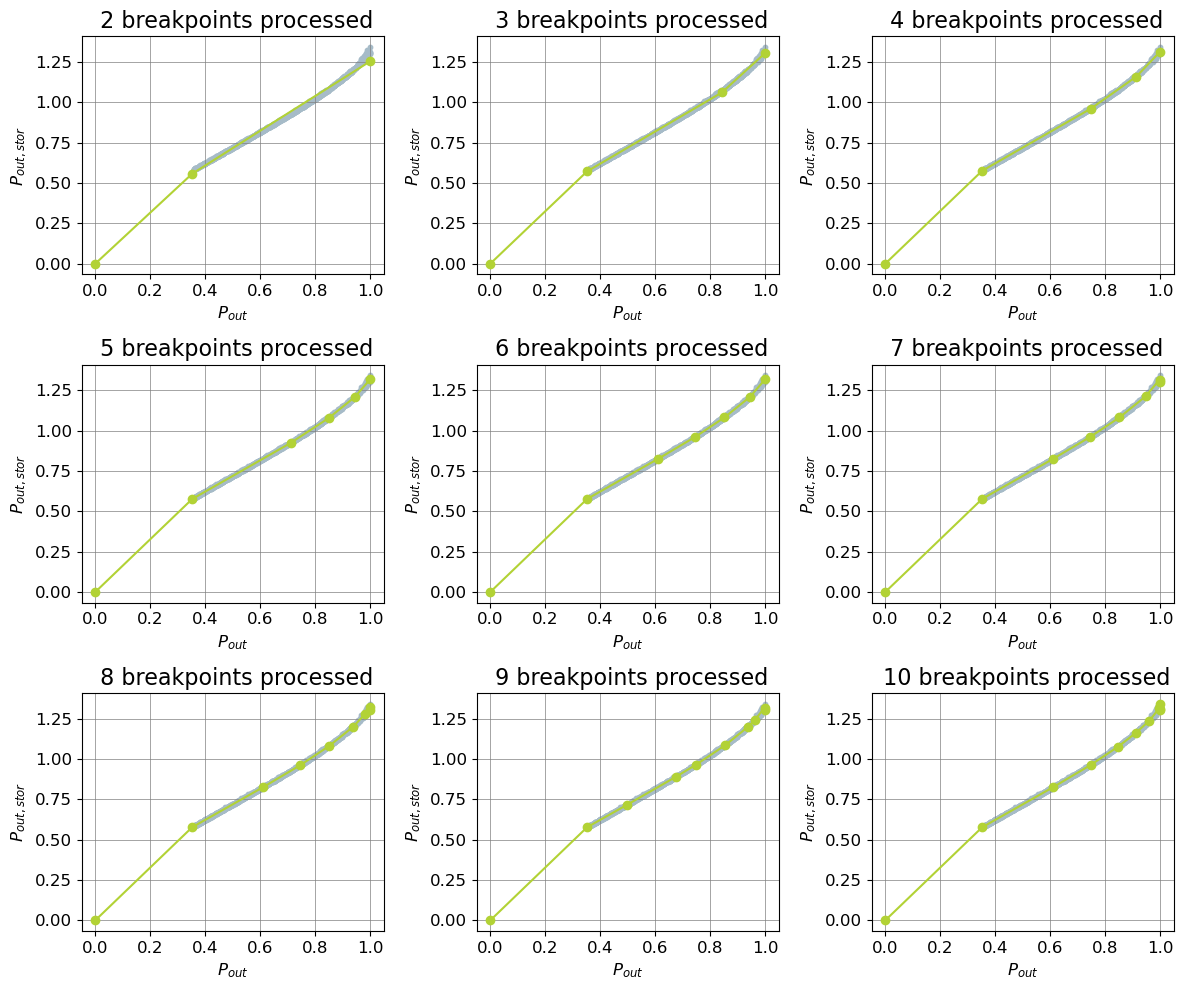

In [22]:
import os
import sys

parent_dir = os.path.realpath("..")
plot_path = os.path.realpath(os.path.join(parent_dir, "plots"))
sys.path.append(plot_path)

from breakpoints import plot_breakpoints_as_subplots, read_data_from_csv

# read original data to be plottet together with breakpoints
# use same data_file as before
parent_dir = os.path.realpath("..")
data_file = os.path.realpath(
    os.path.join(
        parent_dir,
        "design_plan_simulation_results",
        "caes_discharging_efficiency_data.csv",
    )
)
# define column labels of input data
x_value_label = "P_out_rel_new"
y_value_label = "P_out_stor_new"

# read original data for plotting
x_data, y_data = read_data_from_csv(data_file, x_value_label, y_value_label)

processed_breakpoints = True

# define axis labels
x_label = "$P_{out}$"
y_label = "$P_{out, stor}$"

# get column labels of x breakpoints
# get all column labels
all_labels = df_breakpoints.columns
# filter for x breakpoint columns
bp_labels = [label for label in all_labels if not label.startswith("y")]
# filter according to processed_breakpoints = True/False
if processed_breakpoints == True:
    bp_labels = [label for label in bp_labels if not label.endswith("breakpoints")]
else:
    bp_labels = [
        label for label in bp_labels if not label.endswith("breakpoints_processed")
    ]

# plot breakpoints as subplots
plot_breakpoints_as_subplots(
    x_data, y_data, len(bp_labels), df_breakpoints, bp_labels, x_label, y_label
)


To only plot the original data and breakpoints for a specific number of breakpoints use the following code:

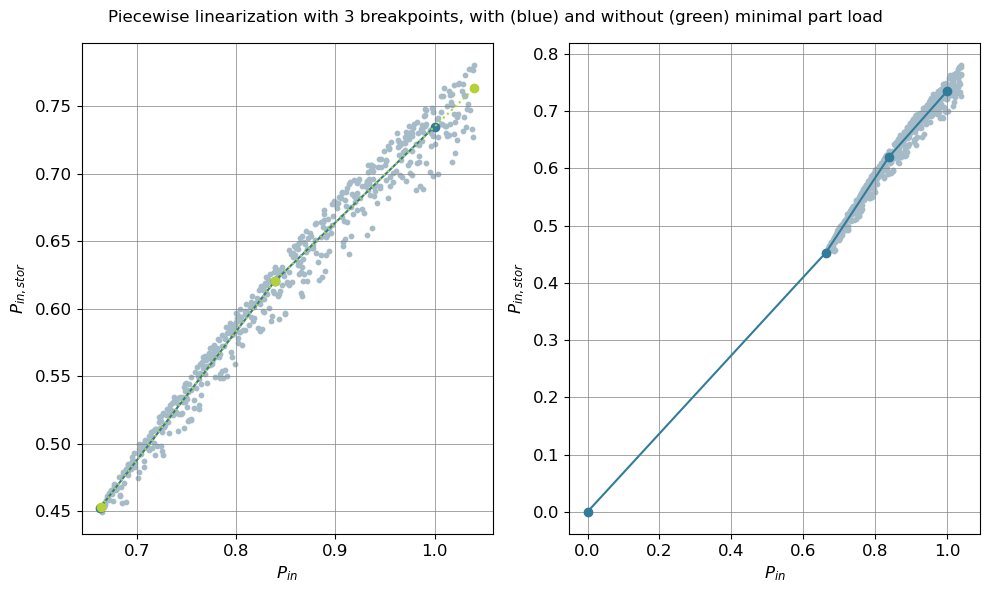

In [4]:
import os
import sys

parent_dir = os.path.realpath("..")
plot_path = os.path.realpath(os.path.join(parent_dir, "plots"))
sys.path.append(plot_path)

from breakpoints import plot_breakpoints_processed, read_data_from_csv

# read original data to be plottet together with breakpoints
# use same data_file as before
data_file = data_file

# define column labels of input data
x_value_label = "P_ein_rel"
y_value_label = "P_ein_stor"

x_data, y_data = read_data_from_csv(data_file, x_value_label, y_value_label)

# number of breakpoints to plot
# change for different number of breakpoints
n_bp = 3

# extract breakpoints for number_of_breakpoints = n_bp
x_breakpoints = df_breakpoints["x_" + str(n_bp) + "_breakpoints"]
y_breakpoints = df_breakpoints["y_" + str(n_bp) + "_breakpoints"]

# extract processed breakpoints for number_of_breakpoints = n_bp
x_bp_processed = df_breakpoints["x_" + str(n_bp) + "_breakpoints_processed"]
y_bp_processed = df_breakpoints["y_" + str(n_bp) + "_breakpoints_processed"]

# define axis labels
x_label = "$P_{in}$"
y_label = "$P_{in,stor}$"

# plot processed breakpoints
plot_breakpoints_processed(
    x_data,
    y_data,
    x_breakpoints,
    y_breakpoints,
    x_bp_processed,
    y_bp_processed,
    x_label,
    y_label,
)
